In [ ]:
pip install cdsapi  #Installing cdsapi

In [ ]:
#Here I have mentioned the my UID:API key. One can replace it with his/her own.  
url = 'url:https://cds.climate.copernicus.eu/api/v2'
key = 'key:62276:be0ea6fa-ec28-46ea-9517-c6d5acd74af4'
with open('/root/.cdsapirc', 'w') as f:
    f.write('\n'.join([url, key]))

with open('/root/.cdsapirc') as f:
    print(f.read())

url:https://cds.climate.copernicus.eu/api/v2
key:62276:be0ea6fa-ec28-46ea-9517-c6d5acd74af4


In [ ]:
pip install eccodes

In [ ]:
!apt-get -qq install -y libeccodes0 python-cartopy python3-cartopy #Installing suppporting library for eccodes. You may not need to run this command.

In [ ]:
import pandas as pd
import numpy as np
from geopy.distance import great_circle as vc
from datetime import datetime
import csv
import math
import os
import datetime
import cdsapi
BASIN = 'WP2020-21' # set WP or SP or EP or NI or SI or NA 
path = path = os.getcwd()
#path = '/content/drive/MyDrive/AAAICode' # Replace with your current path
path1 = path + '/'+BASIN+'/'
data = pd.read_csv(path + '/ibtracs.since1980.list.v04r00.csv')
data1 = data[data['BASIN'] == 'WP']
columns = ['SID', 'ISO_TIME','DIST2LAND','LAT','LON','STORM_SPEED','STORM_DIR']
data2 = data1[columns]

#Retaining data from May 2020 onwards
data2 = data2[data2['ISO_TIME'] > '2020-05-00 00:00:00']

#Creating the folder for the BASIN
if not os.path.exists(path1):
    os.makedirs(path1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,8,9,14,19,20,25,161,162) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
data2.head()

SID             ISO_TIME  ... STORM_SPEED STORM_DIR
269538  2020133N10129  2020-05-11 18:00:00  ...           5       350
269539  2020133N10129  2020-05-11 21:00:00  ...           5         2
269540  2020133N10129  2020-05-12 00:00:00  ...           6        13
269541  2020133N10129  2020-05-12 03:00:00  ...           7        16
269542  2020133N10129  2020-05-12 06:00:00  ...           7       356

[5 rows x 7 columns]

In [ ]:
def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

def getValue(value):
  try:
    float(value)
    return float(value)
  except ValueError:
    return None


In [ ]:
dataValues =  data2.values
sidIndex = data2.columns.get_loc('SID')
timeIndex = data2.columns.get_loc('ISO_TIME')
d2lIndex = data2.columns.get_loc('DIST2LAND')
latIndex = data2.columns.get_loc('LAT')
lonIndex = data2.columns.get_loc('LON')
speedIndex = data2.columns.get_loc('STORM_SPEED')
dirIndex = data2.columns.get_loc('STORM_DIR')

alldata = []
for val in dataValues:
  data = []
  sid = val[sidIndex]
  time = val[timeIndex]
  d2l = getValue(val[d2lIndex])
  lat = getValue(val[latIndex])
  lon = getValue(val[lonIndex])
  speed = getValue(val[speedIndex])
  dir = getValue(val[dirIndex])


  data.append(sid)
  data.append(time)
  data.append(d2l)
  data.append(lat)
  data.append(lon)
  data.append(speed)
  data.append(dir)

  alldata.append(data)
data2 = pd.DataFrame(alldata, columns = ['SID', 'ISO_TIME','DIST2LAND','LAT','LON','distance','direction'])

In [ ]:
d2lIndex = data2.columns.get_loc('DIST2LAND')
sidIndex = data2.columns.get_loc('SID')
sids = pd.unique(data2['SID'])
alldata = []
landfalCount = 0
notLandfallCount = 0
minOverOcean = 17 # Taking only those TC which present over ocean for first 48 hours.
y = [] # To keep record of landfall time
totalL = 0 # Total landfall time to get avergae landfall time
minL = 10000000 # To keep 
maxL = -100000000

for sid in sids:
  cyclonData = data2[data2['SID'] == sid]
  valuesC = cyclonData.values
  length = len(valuesC)
  if length <= minOverOcean+1:
    continue
  overOcean = True # To check if the TC present over ocea for first 48 hours.
  for i in range(minOverOcean):
    d2l = int(valuesC[i][d2lIndex])
    if d2l == 0:
      overOcean = False
      break
  # If not present over ocean for first 48 hours , leave the TC
  if not overOcean:
    continue
  
  isLandfall = 0
  j = minOverOcean
  #Checking if landfall happen or not.
  while(j<length):
    d2l = int(valuesC[j][d2lIndex])
    if d2l == 0:
        isLandfall = 1
        break
    j = j+1;

  lastDataIndex = j
  #If landfall happen keeping record of Min, Max, Average time to landfall.
  if isLandfall==1:
    landfalCount = landfalCount +1
    totalL = totalL + lastDataIndex
    if lastDataIndex < minL:
      minL =  lastDataIndex
    if lastDataIndex > maxL:
      maxL = lastDataIndex
    lastDataIndex = j- 8 # Keeping data atleast 24 hours before, if landfall happen
    y.append(j*3)
  else:
    notLandfallCount = notLandfallCount + 1
  
  # Keeping maximum 72 hours of data
  if lastDataIndex >25:
    lastDataIndex =  25

  #Keeping only 6 hourly data. Original data is 3 hourly. 
  for i in range(0, lastDataIndex, 2):
    val = valuesC[i]
    val = np.append(val, isLandfall)
    alldata.append(val)

print("Average Landfall time ", (totalL/landfalCount)*3)
print("max landfall time  ", maxL*3)
print("min landfall time  ", minL*3)

dataa = pd.DataFrame(alldata, columns = ['SID', 'ISO_TIME','DIST2LAND','LAT','LON','distance','direction','isLandfall'])
dataa.to_csv(path1+BASIN+'OceanCenter1.csv')  

print("landfalCount  ", landfalCount)
print("notLandfallCount  ", notLandfallCount)

Average Landfall time  91.66666666666667
max landfall time   156
min landfall time   57
landfalCount   9
notLandfallCount   9


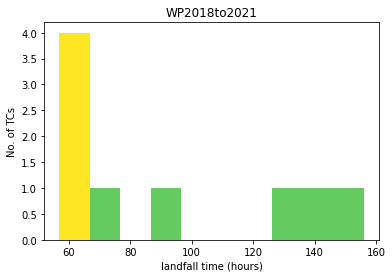

In [ ]:
#Generating histogram o f landfall time distribuiton
import matplotlib.pyplot as plt
from matplotlib import colors
fig,ax = plt.subplots(1,1)
N, bins, patches = ax.hist(y, bins = 10)
# Setting color
fracs = ((N**(1 / 5)) / N.max())
norm = colors.Normalize(fracs.min(), fracs.max())
 
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

ax.set_title(BASIN)
#ax.set_xticks([0,25,50,75,100])
ax.set_xlabel('landfall time (hours)')
ax.set_ylabel('No. of TCs')
plt.show()

In [ ]:
import os
import os.path

spread = 8 # Degree spread around center of cyclone. Taking 8 degree data around the TC center.

#Function to get u, v, wind and z geopotenital at three pressure levels  for a grid centerd at cyclone location. 
def getPressureData(cdsApi, year, month, date, time, lati, long, path):
  time1 = time.replace(':','_')
  fileName = path+ date +month+year+'_'+time1+'.grib'
  print('fileName  ', fileName)
  if os.path.isfile(fileName):
    print("file already exist")
    return
  cdsApi.retrieve(
    'reanalysis-era5-pressure-levels',
    {
        'product_type': 'reanalysis',
        'variable': [
             'geopotential', 'u_component_of_wind', 'v_component_of_wind',
        ],
        'pressure_level': [
            '225', '500', '700',
        ],
        'year': [
            year,
        ],
        'month': [
            month,
        ],
        'day': [
            date,
        ],
        'time': [
            time,
        ],
        'format': 'grib',
        'area': [
            lati+spread, long-spread, lati-spread,
            long+spread,
        ],
    },
    fileName)
  
def createFolder(path):
  if not os.path.exists(path):
    os.makedirs(path)
    
#Rounding lat, long to the multiple of 0.25
def roundF(x, base=.25):
    return base * round(x/base)

In [ ]:
data2 = pd.read_csv(path1+BASIN+'OceanCenter1.csv', index_col=0)
sidIndex = data2.columns.get_loc('SID') 
isoTimeIndex = data2.columns.get_loc('ISO_TIME') 
latIndex = data2.columns.get_loc('LAT') 
longIndex = data2.columns.get_loc('LON')
count = 0
dataValues = data2.values
cdsApi = cdsapi.Client()
for data in dataValues:
  print('count  ', count)
  count = count + 1
  sid = data[sidIndex]
  #Creating folder for pressure data
  folder1 = path1+'data/pressure/'+sid+'/'
  createFolder(folder1)
  isoTime = data[isoTimeIndex]
  lat = data[latIndex]
  long = data[longIndex]
  date = datetime.datetime.strptime(isoTime, '%Y-%m-%d %H:%M:%S')
  year = date.year

  year = str(year)
  month = date.month
  day = date.day
  time = date.hour

  if month < 10:
    month = '0'+str(month)
  else:
    month = str(month)

  if day < 10:
    day = '0'+str(day)
  else:
    day = str(day)

  if time<10:
    time = '0'+str(time)+':00'
  else:
    time = str(time) +':00'

  lat = roundF(lat)
  long = roundF(long)
  getPressureData(cdsApi, year, month, day, time, lat, long, folder1)

count   0
fileName   /content/drive/MyDrive/AAAICode/WP2020-21/data/pressure/2020133N10129/11052020_18_00.grib
file already exist
count   1
fileName   /content/drive/MyDrive/AAAICode/WP2020-21/data/pressure/2020133N10129/12052020_00_00.grib
file already exist
count   2
fileName   /content/drive/MyDrive/AAAICode/WP2020-21/data/pressure/2020133N10129/12052020_06_00.grib
file already exist
count   3
fileName   /content/drive/MyDrive/AAAICode/WP2020-21/data/pressure/2020133N10129/12052020_12_00.grib
file already exist
count   4
fileName   /content/drive/MyDrive/AAAICode/WP2020-21/data/pressure/2020133N10129/12052020_18_00.grib
file already exist
count   5
fileName   /content/drive/MyDrive/AAAICode/WP2020-21/data/pressure/2020133N10129/13052020_00_00.grib
file already exist
count   6
fileName   /content/drive/MyDrive/AAAICode/WP2020-21/data/pressure/2020214N21128/01082020_06_00.grib
file already exist
count   7
fileName   /content/drive/MyDrive/AAAICode/WP2020-21/data/pressure/2020214N21128

In [ ]:
#Function that return the .grib file.
def getFileName(folder, isoTime):
    date = datetime.datetime.strptime(isoTime, '%Y-%m-%d %H:%M:%S')

    year = date.year
    year = str(year)
    month = date.month
    day = date.day
    time = date.hour

    if month < 10:
      month = '0'+str(month)
    else:
      month = str(month)

    if day < 10:
      day = '0'+str(day)
    else:
      day = str(day)

    if time<10:
      time = '0'+str(time)+'_00'
    else:
      time = str(time) +'_00'

    file1 = folder+ day +month+year+'_'+time+'.grib'
    return file1

In [ ]:
#Reading .grib files and extracting u, v, z fileds for 65*65 grid.
#For each filed we have created a column for field values at each cell of grid. So for each fields we have 65*65 = 4225 columns.
import eccodes
from eccodes import *
data2 = pd.read_csv(path1+BASIN+'OceanCenter1.csv', index_col = 0, header=0)

sidIndex = data2.columns.get_loc('SID') 
isoTimeIndex = data2.columns.get_loc('ISO_TIME') 
latIndex = data2.columns.get_loc('LAT') 
longIndex = data2.columns.get_loc('LON') 
d2lIndex = data2.columns.get_loc('DIST2LAND')
isLandfallIndex = data2.columns.get_loc('isLandfall')
disIndex = data2.columns.get_loc('distance')
dirIndex = data2.columns.get_loc('direction')

sids = pd.unique(data2['SID'])
gridSize = 65
alldata = []
colums = ['SID', 'ISO_TIME','DIST2LAND','LAT','LON','distance','direction']
check = True
lengthsids = len(sids)

for i in range(lengthsids):
  sid = sids[i]
  print('sid  ',sid)
  cyclonData = data2[data2['SID'] == sid]
  valuesC = cyclonData.values
  length = len(valuesC)

  folder1 = path1 +'/data/pressure/'+sid+'/'
  for i in range(length):
    datac = []
    data = valuesC[i]
    isoTime = data[isoTimeIndex]
    lat = data[latIndex]
    long = data[longIndex]
    d2l = data[d2lIndex]
    isLand = data[isLandfallIndex]
    dis = data[disIndex]
    dir = data[dirIndex]

    datac.append(sid)
    datac.append(isoTime)
    datac.append(d2l)
    datac.append(lat)
    datac.append(long)
    datac.append(dis)
    datac.append(dir)

    pressureFile = getFileName(folder1, isoTime)
    
    id = codes_index_new_from_file(pressureFile, ["shortName",'level'])

    names = codes_index_get(id, "shortName")
    levels = codes_index_get(id, "level")

    for name in names:
      #Getting index for each name (u, v, z)
      codes_index_select(id, "shortName", name)
      for level in levels:
        #Getting index for each leval 225, 500, 700
        codes_index_select(id, "level", level)
        gid = codes_new_from_index(id)
        values = codes_get_values(gid)
        length = len(values)
        # Appening values of field for each location of grid. 
        for i in range(length):
            val = np.float32(values[i])
            datac.append(val)
            #Creating dataset columnds name
            if check:
                colums.append(name+str(level)+'_'+str(i))

    datac.append(isLand)
    if check:
      colums.append('isLandfall')
    alldata.append(datac)
    codes_index_release(id)
    check = False
  
dataa = pd.DataFrame(alldata, columns = colums)
dataa.to_csv(path1+BASIN+'pressureSSTData72hour.csv')

sid   2020133N10129
sid   2020214N21128
sid   2020221N18126
sid   2020223N26148
sid   2020235N23122
sid   2020241N17131
sid   2020245N23146
sid   2020260N13118
sid   2020265N24134
sid   2020271N20159
sid   2020279N23139
sid   2020302N17140
sid   2020304N08148
sid   2020314N12131
sid   2020355N10115
sid   2021048N07133
sid   2021150N06135
sid   2021172N11147
